In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

import json
import pandas as pd
from collections import defaultdict
keras.utils.set_random_seed(111)
from PIL import Image
import random

from nltk.translate.bleu_score import sentence_bleu

In [ ]:
!wget -q http://images.cocodataset.org/zips/train2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qq train2017.zip
!unzip -qq annotations_trainval2017.zip
!rm train2017.zip annotations_trainval2017.zip

In [2]:
# Path to the images
IMAGES_PATH = "train2017"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 30000

# Fixed length allowed for any sequence
SEQ_LENGTH = 40

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 20
AUTOTUNE = tf.data.AUTOTUNE



In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # The result is a text string with only letters, numbers, and spaces.
    text = re.sub('\s+', ' ', text) # replace one or more consecutive whitespace characters with a single space
    text = text.strip()
    text = '<start> ' + text + ' <end>'
    return text

In [4]:
with open('annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_name = os.path.join(IMAGES_PATH, img_name.strip())
    cap = preprocess(sample['caption'])
    img_cap_pairs.append([img_name, cap]) 
    
captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption']) # create list of list as dataframe


#captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,train2017/000000203564.jpg,<start> a bicycle replica with a clock as the ...
1,train2017/000000322141.jpg,<start> a room with blue walls and a white sin...
2,train2017/000000016977.jpg,<start> a car that seems to be parked illegall...
3,train2017/000000106140.jpg,<start> a large passenger airplane flying thro...
4,train2017/000000106140.jpg,<start> there is a gol plane taking off in a p...


In [18]:
captions.groupby('image')['caption'].count().sort_values()

image
train2017/000000000009.jpg    5
train2017/000000387431.jpg    5
train2017/000000387429.jpg    5
train2017/000000387421.jpg    5
train2017/000000387419.jpg    5
                             ..
train2017/000000088005.jpg    6
train2017/000000250802.jpg    6
train2017/000000052109.jpg    7
train2017/000000336464.jpg    7
train2017/000000023247.jpg    7
Name: caption, Length: 118287, dtype: int64

In [5]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(captions['caption'])

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [7]:
vectorization.vocabulary_size()

11747

In [6]:
word2idx = tf.keras.layers.StringLookup(mask_token="", vocabulary=vectorization.get_vocabulary())
idx2word = tf.keras.layers.StringLookup(mask_token="",vocabulary=vectorization.get_vocabulary(),invert=True)

In [7]:
img_cap = defaultdict(list)
for img,cap in zip(captions['image'],captions['caption']):
    img_cap[img].append(cap)
    
img_key = list(img_cap.keys())
random.shuffle(img_key)

slice_index = int(len(img_key) * 0.8)

img_train_key, img_val_key = (img_key[:slice_index],img_key[slice_index:])

train_img = []
train_cap = []
val_img = []
val_cap = []

for imgt in img_train_key:
    num_capt = len(img_cap[imgt])
    train_img.extend([imgt] * num_capt)
    train_cap.extend(img_cap[imgt])
    
for imgv in img_val_key:
    num_capv = len(img_cap[imgv])
    val_img.extend([imgv] * num_capv)
    val_cap.extend(img_cap[imgv])
    
len(train_img),len(train_cap),len(val_img),len(val_cap)

(473406, 473406, 118347, 118347)

In [8]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(train_img,train_cap)

valid_dataset = make_dataset(val_img,val_cap)


In [9]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        with tf.GradientTape() as tape:
            loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq, training=True)
            # 3. Update loss and accuracy
            batch_loss += loss
            batch_acc += acc

            # 4. Get the list of all the trainable weights
        train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)

        # 5. Get the gradients
        grads = tape.gradient(loss, train_vars)

        # 6. Update the trainable weights
        self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }
    

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq, training=False)

        # 3. Update batch loss and batch accuracy
        batch_loss += loss
        batch_acc += acc

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [10]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='none',
)

# EarlyStopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/5
7397/7397 [==============================] - 2740s 369ms/step - loss: 3.7888 - acc: 0.2784 - val_loss: 2.7112 - val_acc: 0.4656
Epoch 2/5
7397/7397 [==============================] - 2767s 374ms/step - loss: 2.7041 - acc: 0.4586 - val_loss: 2.5441 - val_acc: 0.4841
Epoch 3/5
7397/7397 [==============================] - 2710s 366ms/step - loss: 2.5698 - acc: 0.4757 - val_loss: 2.4845 - val_acc: 0.4911
Epoch 4/5
7397/7397 [==============================] - 2712s 367ms/step - loss: 2.4911 - acc: 0.4853 - val_loss: 2.4466 - val_acc: 0.4956
Epoch 5/5
7397/7397 [==============================] - 2718s 367ms/step - loss: 2.4338 - acc: 0.4924 - val_loss: 2.4324 - val_acc: 0.4973


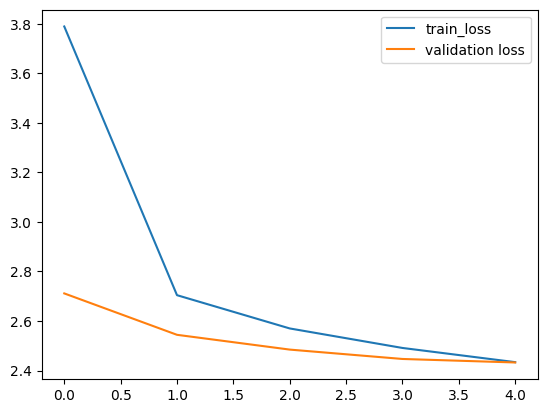

In [13]:
plt.plot(caption_model.history.history['loss'], label='train_loss')
plt.plot(caption_model.history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [31]:
caption_model.save_weights('ImageCaption_CocoDs', save_format='tf')

In [33]:
# Recreate the model
new_model = caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)
new_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Load the state of the old model
new_model.load_weights('ImageCaption_CocoDs')


Reference caption:
a woman holds an umbrella as she leaves a store

woman looking across while holding a umbrella in front of a building

a man is holding an umbrella that matches the building behind her

a woman walking in the rain while carrying an umbrella

a woman carries an umbrella and she walks down a street

Predicted Caption: a woman holding an umbrella in front of a building
BLEU score -> 0.6985342056580097


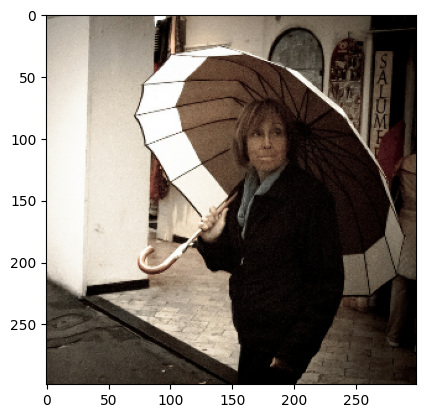

Reference caption:
a gray cat laying in the bathroom sink

a cat sitting in the sink of a bathroom

an adult cat laying in a bathroom sink

a gray cat sleeping inside of a glass bowl

a cat is lying in the bathroom sink

Predicted Caption: a cat sitting in a bowl on a table
BLEU score -> 0.3549481056010053


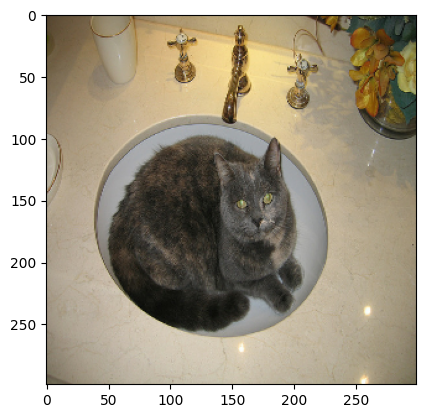

Reference caption:
two young women brushing their teeth in a bathroom

two women with toothbrushes in a room

two girls are in the bathroom brushing their teeth

two friends brush their teeth together using toothbrushes

two friends are brushing their teeth together and goofing around

Predicted Caption: two women are holding a toothbrush in their mouth
BLEU score -> 8.014508691042773e-155


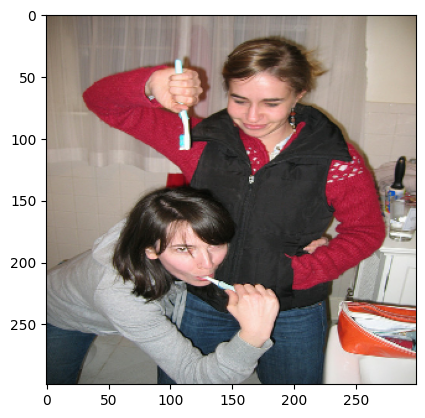

In [60]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = new_model.cnn_model(img)
    img_encoded = new_model.encoder(img_embed, training=False)

    y_inp = '<start>'
    for i in range(SEQ_LENGTH-1):
        tokenized = vectorization([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = new_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '<end>':
            break
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('<start> ', '')
    return y_inp


reference = []   
for i in range(0,3):
    idx = random.randrange(0, len(captions))
    img_path = captions.iloc[idx].image
    print("Reference caption:")
    for idx,cap in captions.loc[captions['image'] == img_path,'caption'].items():
        cap = cap.replace("<start> ", "")
        cap = cap.replace("<end>", "").strip()
        print(cap)
        print()
        reference.append(cap.split())
    decoded_caption = generate_caption(img_path)
    print("Predicted Caption:", decoded_caption)
    candidate = decoded_caption.split()
    print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))  
    sapmle_img = decode_and_resize(img_path)
    sapmle_img = sapmle_img.numpy().clip(0,255).astype(np.uint8)
    plt.imshow(sapmle_img)
    plt.show()
    reference.clear()